# Homework - Neural Networks & Natural Language Processing

***Agata Makarewicz***

*Week 17*

## 0. Introduction

Task: classification

IMDB Reviews data

In [1]:
# loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

import nltk
from nltk import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, auc, plot_roc_curve, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import metrics
from wordcloud import WordCloud,STOPWORDS

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

import plotly
import plotly.graph_objects as go
import plotly.express as px
plotly.io.renderers.default = 'colab'

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [143]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
from gensim.models import Word2Vec, Phrases
import os
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score


In [180]:
# helper function
def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.title(title)

In [2]:
from bds_courseware import read_drive_dataset, HOMEWORK_DATASETS

name = "movies"
data = read_drive_dataset(*HOMEWORK_DATASETS[name])

## I. EDA & preprocessing

### I.I EDA

In [3]:
data.shape

(50000, 2)

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


We can see that we have only two columns - `review` and `sentiment`, and none of them contains missing values. We can also spot some "words" which we will drop later on, such as HTML tags.

Let's take a closer look how one review looks like.

In [6]:
data.loc[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Let's now see how long (on average) our reviews are.

In [7]:
letters = [len(row) for row in data['review']] # letter count
splitted = [x.split() for x in data['review']] # word count
words = [len(x) for x in splitted]

In [8]:
stats = pd.concat([pd.DataFrame(letters).rename(columns={0: 'n_letters'}),
                   pd.DataFrame(words).rename(columns={0: 'n_words'})], axis=1)
stats.describe()

,n_letters,n_words
count,50000.000000,50000.000000
mean,1309.431020,231.156940
std,989.728014,171.343997
min,32.000000,4.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.250000,280.000000
max,13704.000000,2470.000000


We can see that shortest review has only 4 words, but it can be misleading - we are now performing very basic EDA and splitting words by `space`, but it is possible that someone forgot to put it after a comma. Let's check out this record.

In [9]:
data['review'][np.argmin(stats['n_words'])]

'Primary plot!Primary direction!Poor interpretation.'

There are in fact 6 words instead of four in this review. Later on we will perform tokenization which will handle such situations as missing spaces between words (splitting the words better).

But we are interested in distinction between positive and negative reviews - let's check how it looks like for each of them.

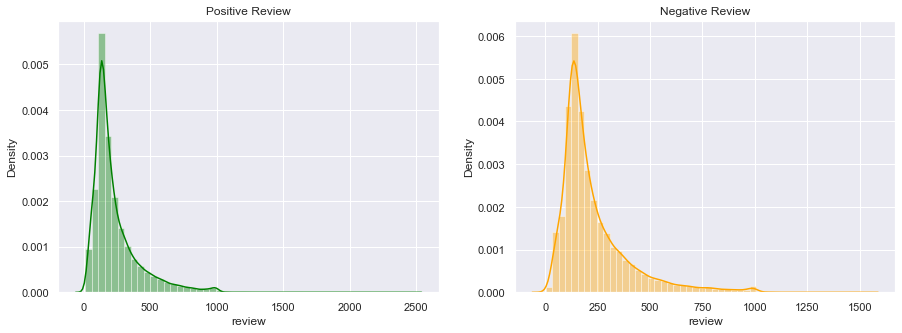

In [10]:
def plot_count(count1,count2,title_1,title_2):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count1,ax = ax1,color = 'Green')
    ax1.set_title(title_1)
    sns.distplot(count2,ax = ax2,color = 'Orange')
    ax2.set_title(title_2)
    plt.show()    

count_good = data.query('sentiment=="positive"')['review'].str.split().apply(lambda z: len(z))
count_bad = data.query('sentiment=="negative"')['review'].str.split().apply(lambda z: len(z))
plot_count(count_good,count_bad,"Positive Review","Negative Review")

In [11]:
stats2 = pd.concat([pd.DataFrame(count_good).rename(columns={'review': 'count_good'}),
                   pd.DataFrame(count_bad).rename(columns={'review': 'count_bad'})], axis=1)
stats2.describe()

,count_good,count_bad
count,25000.000000,25000.000000
mean,232.849320,229.464560
std,177.497046,164.947795
min,10.000000,4.000000
25%,125.000000,128.000000
50%,172.000000,174.000000
75%,284.000000,278.000000
max,2470.000000,1522.000000


There's practically no difference between the length of positive and negative reviews - one thig we can observe is that there are more longer reviews in case of positives (but they are rare). Further EDA will be performed after cleaning & tokenization.

#### Target analysis

positive    25000
negative    25000
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

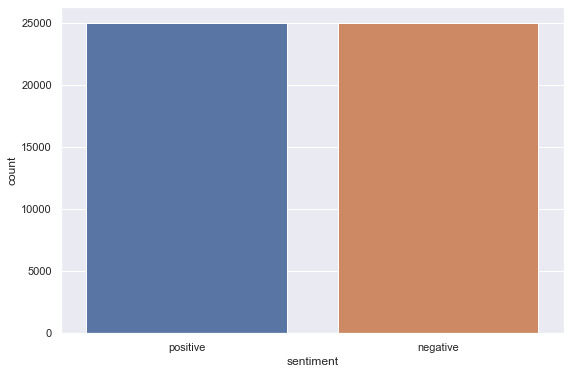

In [12]:
print(data.sentiment.value_counts())
sns.countplot(data['sentiment'])

As we can see, our target is perfectly balanced. Let's change it to binary one.

In [13]:
data['sentiment'] = data['sentiment'].replace({'positive':1,'negative':0})

### I.II Cleaning & preprocessing

In [14]:
# Remove HTML - some html tags present in the data, not important
def clean_html(data):
    html_clean = re.compile(r'<.*?>')
    data = html_clean.sub(r'',data)
    return data

In [15]:
# Remove URL - sometimes a website included, also not informative
def clean_url(data):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    data = url_clean.sub(r'',data)
    return data

In [16]:
# Modify to lower - to reduce number of words and exclude duplicates differing by letter case
def clean_to_lower(text):
    return text.lower()

In [17]:
# Remove punctuations - all special chars 
def clean_special_char(data): # and numbers - also not very informative without context
    data = re.sub('\[[^]]*\]', ' ', data)
    data = re.sub('[^a-zA-Z]', ' ', data)
    return data

In [18]:
# all cleaning together
def clean_data(data):
    data = data.apply(clean_html).apply(clean_url).apply(clean_to_lower).apply(clean_special_char)
    return data

In [19]:
# tokenization and stopwords removal
def tokenize_and_remove_stopwords(row):
    token = word_tokenize(row) 
    filtered_token = []
    for word in token:
        if word not in stopwords.words('english'):
            filtered_token.append(word)
    return filtered_token

In [27]:
# lemmatization
def lemmatizer(data):
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(row) for row in data]
    text = " ".join(text)
    return text

## II. Modeling

We will start with baseline model with hyperparameters tuned, and then move on to more complex ones - recurrent neural networks.

#### Metrics

Given our classes are balanced, we can freely use *Accuracy* for evaluation. Better choice for text classification would be *Precision*, *Recall*, or *F1-score* including them both, however the framework used (Keras) doesn't have a default implementation to use (we would need to define those metrics by ourselves). 
We could also use ROC-AUC here, but this idea came in the middle of the training process which is quite time-consuming and it was too late to change it ;)

#### Train-test split

In [20]:
data_train, data_test, target_train, target_test = train_test_split(data['review'], data['sentiment'], 
                                                                    test_size=0.2, shuffle=True, random_state=123)

#### Preprocessing

In [23]:
# cleaning
data_train_clean = clean_data(data_train)
data_test_clean = clean_data(data_test)

In [24]:
# tokenization (just to remove stopwords)
data_train_tok = data_train_clean.apply(tokenize_and_remove_stopwords)
data_test_tok = data_test_clean.apply(tokenize_and_remove_stopwords)

In [28]:
# lemmatization
data_train_lemma = data_train_tok.apply(lemmatizer)
data_test_lemma = data_test_tok.apply(lemmatizer)

#### Wordcloud

In [220]:
# separating positive and negative reviews
positive_ind = target_train[target_train==1].index.to_list()
negative_ind = target_train[target_train==0].index.to_list()

In [221]:
def plot_wordcloud(tokens): # filtering out words which are most common in both positive and negative
    words = ''              # based on the knowledge from above and some experiments ;)       
    for token in tokens: 
        words += " ".join(token)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=['movie','film','character','one','show','even','like','time','get','also','make','see','would','scene'],
                    min_font_size = 10).generate(words)                        
    plt.figure(figsize = (9,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

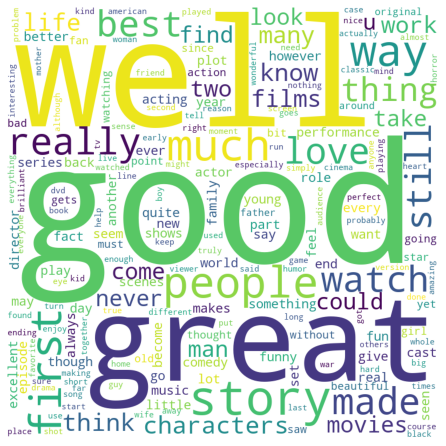

In [222]:
plot_wordcloud(data_train_tok[positive_ind]) # word cloud for positive reviews

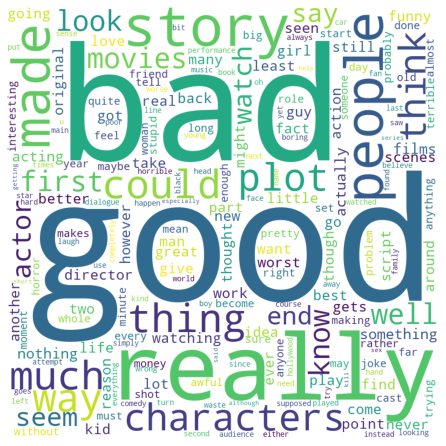

In [223]:
plot_wordcloud(data_train_tok[negative_ind]) # word cloud for negative reviews

Wordclouds for each class after deleting obvious common words look predictably, excluding `good` in case of bad reviews - however, it was possibly a bi-gram like `not good` but `not` was deleted as a stopword.

### II.I Baseline model - logistic regression + TF-IDF

As said before, we will start with simple model from linear 'family'. As vectorizer, TF-IDF will be used.

In [206]:
sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=1000)), # stop_words='english', 
    ('model', SGDClassifier())
])

tuned_parameters = [{'model__alpha': [0.1, 1.0, 5, 10], 
                     'model__loss': ['log'], 
                     'model__penalty': ['l2', 'elasticnet']}]

grid_search_base = GridSearchCV(sgd_pipe, param_grid=tuned_parameters,
                                cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [207]:
grid_search_base.fit(data_train_lemma, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=   1.7s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=   1.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=   1.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=   1.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=   1.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=   1.4s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=   1.4s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=   1.3s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=   1.4s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=   1.5s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=   1.4

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=1000,
                                                        ngram_range=(1, 3))),
                                       ('model', SGDClassifier())]),
             param_grid=[{'model__alpha': [0.1, 1.0, 5, 10],
                          'model__loss': ['log'],
                          'model__penalty': ['l2', 'elasticnet']}],
             scoring='f1', verbose=2)

In [208]:
grid_search_base.best_params_

{'model__alpha': 0.1, 'model__loss': 'log', 'model__penalty': 'l2'}

In [209]:
y_pred = grid_search_base.predict(data_test_lemma)

In [210]:
print('Accuracy: {0}'.format(accuracy_score(y_pred, target_test)))

Accuracy: 0.788


Confusion matrix: 


<AxesSubplot:>

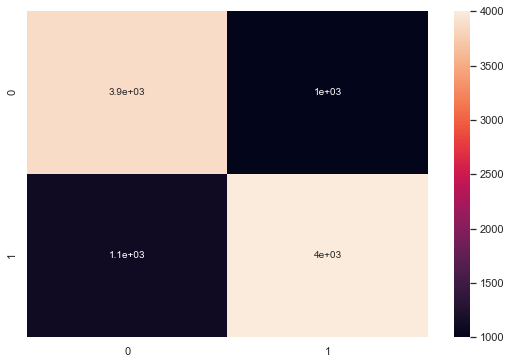

In [211]:
print('Confusion matrix: ')
sns.heatmap(confusion_matrix(y_pred, target_test), annot=True)

As we can see, baseline model performs quite well with proper hyperparameters. Let's see if we will be able to improve that result.

### II.II RNN model - LSTM

In [264]:
# tokenization for word2vec
data_train_final = [*map(lambda text: word_tokenize(text), data_train_lemma)]
data_test_final = [*map(lambda text: word_tokenize(text), data_test_lemma)]

In [265]:
# pretrained embedding
word_model = Word2Vec(data_train_final, size=300, min_count=1, window=5, iter=100)
pretrained_weights = word_model.wv.vectors

In [266]:
# text to integers
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data_train_lemma.values)
X = tokenizer.texts_to_sequences(data_train_lemma.values)

vocab_size = len(tokenizer.word_index)+1

In [267]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    try:
        embedding_value = word_model[word]
        if embedding_value is not None:
            embedding_matrix[i] = embedding_value         
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),300)       

In [173]:
# model
embid_dim = 300
lstm_out = 128

model = Sequential()
model.add(Embedding(vocab_size, 300, input_length =300, weights = [embedding_matrix ] , trainable = False))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

In [174]:
# callback that saves the model's weights
checkpoint_path = "checkpoints/lstm"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# early stopping on val_loss
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [175]:
# optimizer and metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [176]:
# training data
x_train = pad_sequences(X, maxlen=300)
y = target_train

In [178]:
# training
batch_size = 2000
epochs = 20
history = model.fit(
    x_train, y, epochs=epochs, validation_split = 0.2, batch_size=batch_size, callbacks=[early_stop, cp_callback])

Epoch 1/20
16/16 [==============================] - 31s 2s/step - loss: 0.4333 - accuracy: 0.8319 - val_loss: 0.4019 - val_accuracy: 0.8200

Epoch 00001: saving model to checkpoints\lstm
Epoch 2/20
16/16 [==============================] - 46s 3s/step - loss: 0.3481 - accuracy: 0.8662 - val_loss: 0.3858 - val_accuracy: 0.8400

Epoch 00002: saving model to checkpoints\lstm
Epoch 3/20
16/16 [==============================] - 25s 2s/step - loss: 0.2875 - accuracy: 0.8850 - val_loss: 0.3770 - val_accuracy: 0.8475

Epoch 00003: saving model to checkpoints\lstm
Epoch 4/20
16/16 [==============================] - 24s 1s/step - loss: 0.2493 - accuracy: 0.9081 - val_loss: 0.3930 - val_accuracy: 0.8500

Epoch 00004: saving model to checkpoints\lstm
Epoch 5/20
16/16 [==============================] - 26s 2s/step - loss: 0.2096 - accuracy: 0.9381 - val_loss: 0.4088 - val_accuracy: 0.8575

Epoch 00005: saving model to checkpoints\lstm
Epoch 6/20
16/16 [==============================] - 24s 1s/step -

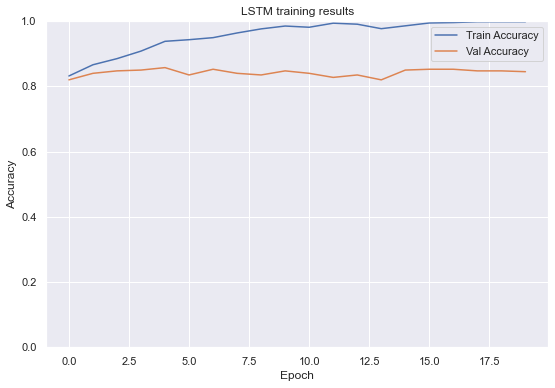

In [182]:
# plotting the learning curve
plot_history(history, 'LSTM training results')

Accuracy: 0.818
Confusion matrix:


<AxesSubplot:>

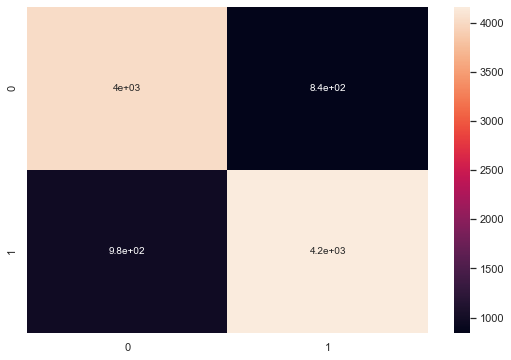

In [188]:
# testing
list_tokenized_test = tokenizer.texts_to_sequences(data_test_lemma)
x_test = pad_sequences(list_tokenized_test, maxlen=300)

prediction = model.predict(x_test)
y_pred = (prediction > 0.5)
print('Accuracy: {0}'.format(accuracy_score(y_pred, target_test)))
print('Confusion matrix:')
sns.heatmap(confusion_matrix(y_pred, target_test), annot=True)

As we can see, the result is good - we get accuracy above 0.8. However, we can see on the plot of the learning curve, that we possibly deal with overfitting. 

Let's tune some hyperparameters to see if we can improve accuracy. Due to long computional time, only some of the parameters will be tuned.


In [193]:
# hyperparameters tuning
dropout_lstm = [0.1, 0.2]
dense_unit = [10, 20]
dropout_last = [0.05, 0.1]
batch_size = [1000, 2000] 

param_scores = []
params = []
for d_lstm in dropout_lstm:
    for d_unit in dense_unit:
        for d_last in dropout_last:
            for b in batch_size:
    
                model = Sequential()
                model.add(Embedding(vocab_size, 300, input_length =300, weights = [embedding_matrix] , trainable = False))
                model.add(LSTM(lstm_out, dropout=d_lstm, return_sequences=True))
                model.add(GlobalMaxPool1D())
                model.add(Dense(d_unit, activation="relu"))
                model.add(Dropout(d_last))
                model.add(Dense(1, activation="sigmoid"))
                
                model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
                
                history = model.fit(x_train, y, epochs=10, 
                                    validation_split = 0.2, batch_size=b, 
                                    callbacks=[early_stop, cp_callback])
    
                param_score = history.history['val_accuracy']
                param_scores.append(param_score[-1])
                params.append([d_lstm,d_unit,d_last,b])
                print('+-'*50) 

Epoch 1/10
32/32 [==============================] - 26s 726ms/step - loss: 0.6673 - accuracy: 0.5768 - val_loss: 0.4901 - val_accuracy: 0.8050

Epoch 00001: saving model to checkpoints\lstm
Epoch 2/10
32/32 [==============================] - 23s 711ms/step - loss: 0.4395 - accuracy: 0.8238 - val_loss: 0.3983 - val_accuracy: 0.8100

Epoch 00002: saving model to checkpoints\lstm
Epoch 3/10
32/32 [==============================] - 26s 817ms/step - loss: 0.3389 - accuracy: 0.8649 - val_loss: 0.4027 - val_accuracy: 0.8375

Epoch 00003: saving model to checkpoints\lstm
Epoch 4/10
32/32 [==============================] - 24s 760ms/step - loss: 0.2283 - accuracy: 0.9164 - val_loss: 0.3686 - val_accuracy: 0.8350

Epoch 00004: saving model to checkpoints\lstm
Epoch 5/10
32/32 [==============================] - 24s 767ms/step - loss: 0.1810 - accuracy: 0.9386 - val_loss: 0.3725 - val_accuracy: 0.8375

Epoch 00005: saving model to checkpoints\lstm
Epoch 6/10
32/32 [==============================] 

32/32 [==============================] - 30s 932ms/step - loss: 0.3450 - accuracy: 0.8603 - val_loss: 0.3639 - val_accuracy: 0.8475

Epoch 00003: saving model to checkpoints\lstm
Epoch 4/10
32/32 [==============================] - 30s 943ms/step - loss: 0.2734 - accuracy: 0.9008 - val_loss: 0.4535 - val_accuracy: 0.8050

Epoch 00004: saving model to checkpoints\lstm
Epoch 5/10
32/32 [==============================] - 29s 906ms/step - loss: 0.2644 - accuracy: 0.9016 - val_loss: 0.4050 - val_accuracy: 0.8050

Epoch 00005: saving model to checkpoints\lstm
Epoch 6/10
32/32 [==============================] - 30s 946ms/step - loss: 0.2618 - accuracy: 0.9158 - val_loss: 0.3360 - val_accuracy: 0.8500

Epoch 00006: saving model to checkpoints\lstm
Epoch 7/10
32/32 [==============================] - 28s 867ms/step - loss: 0.1758 - accuracy: 0.9476 - val_loss: 0.4095 - val_accuracy: 0.8350

Epoch 00007: saving model to checkpoints\lstm
Epoch 8/10
32/32 [==============================] - 25s 794ms

In [201]:
p = np.argmax(np.array(param_scores))
best_params = params[p]
print("Best parameter set: ", best_params) # dropout_lstm, dense_unit, dropout_last, batch_size
print('Score after 10 epochs:', param_scores[p])

Best parameter set:  [0.1, 10, 0.1, 1000]
Score after 10 epochs: 0.8550000190734863


After tuning we get better accuracy after only 10 epochs, and we can see that indeed, parameters are different from the default ones - bigger dropout value before last layer, less units in Dense layer and smaller dropout in LSTM layer. It is possible, that with tuning more parameters for instance learning rate of the optimizer, we could get even better result.

### II.III RNN model - Bidirectional LSTM

In [198]:
# model
embid_dim = 300
lstm_out = 128

model = Sequential()
model.add(Embedding(vocab_size, 300, input_length =300, weights = [embedding_matrix ] , trainable = False))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

In [199]:
# callback that saves the model's weights
checkpoint_path = "checkpoints/bi-lstm"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# early stopping on val_loss
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [200]:
# optimizer and metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [202]:
# training
batch_size = 1000
epochs = 20
history = model.fit(
    x_train, y, epochs=epochs, validation_split = 0.2, batch_size=batch_size, callbacks=[early_stop, cp_callback])

Epoch 1/20
32/32 [==============================] - 71s 2s/step - loss: 0.6505 - accuracy: 0.6430 - val_loss: 0.4731 - val_accuracy: 0.8075

Epoch 00001: saving model to checkpoints\bi-lstm
Epoch 2/20
32/32 [==============================] - 67s 2s/step - loss: 0.4291 - accuracy: 0.8214 - val_loss: 0.3660 - val_accuracy: 0.8450

Epoch 00002: saving model to checkpoints\bi-lstm
Epoch 3/20
32/32 [==============================] - 65s 2s/step - loss: 0.2983 - accuracy: 0.8810 - val_loss: 0.3544 - val_accuracy: 0.8525

Epoch 00003: saving model to checkpoints\bi-lstm
Epoch 4/20
32/32 [==============================] - 65s 2s/step - loss: 0.2395 - accuracy: 0.9115 - val_loss: 0.3666 - val_accuracy: 0.8500

Epoch 00004: saving model to checkpoints\bi-lstm
Epoch 5/20
32/32 [==============================] - 62s 2s/step - loss: 0.2170 - accuracy: 0.9282 - val_loss: 0.4091 - val_accuracy: 0.8350

Epoch 00005: saving model to checkpoints\bi-lstm
Epoch 6/20
32/32 [==============================] 

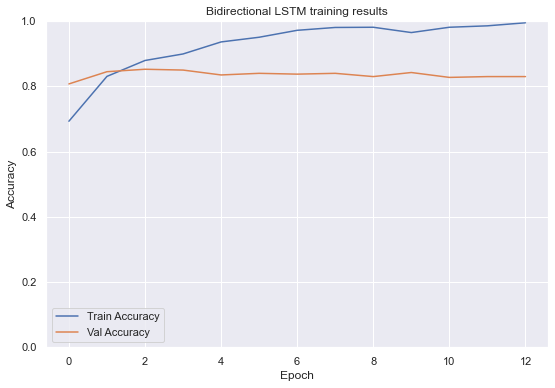

In [203]:
# plotting the learning curve
plot_history(history, 'Bidirectional LSTM training results')

With chosen parameters, we can see there's practically no improvement through the epochs, and we can see that early stopping caused the training to end early. 

Accuracy: 0.838
Confusion matrix:


<AxesSubplot:>

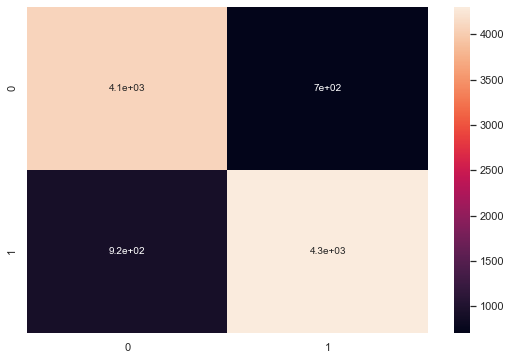

In [205]:
# testing
list_tokenized_test = tokenizer.texts_to_sequences(data_test_lemma)
x_test = pad_sequences(list_tokenized_test, maxlen=300)

prediction = model.predict(x_test)
y_pred = (prediction > 0.5)
print('Accuracy: {0}'.format(accuracy_score(y_pred, target_test)))
print('Confusion matrix:')
sns.heatmap(confusion_matrix(y_pred, target_test), annot=True)

Accuracy score is a bit lower than tuned LSTM model, and higher than the first tried one. However as mentioned above, there's no visible improvement which is not good.

### II.IV RNN model - GRU (additional)

In [268]:
embid_dim = 300
gru_out = 128

model = Sequential()
model.add(Embedding(vocab_size, 300, input_length =300, weights = [embedding_matrix ] , trainable = False))
model.add(GRU(gru_out, dropout=0.2, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

In [269]:
# callback that saves the model's weights
checkpoint_path = "checkpoints/gru"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# early stopping on val_loss
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [270]:
# optimizer and metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [272]:
# training
batch_size = 1000
epochs = 20
history = model.fit(
    x_train, y, epochs=epochs, validation_split = 0.2, batch_size=batch_size, callbacks=[early_stop, cp_callback])

Epoch 1/20
32/32 [==============================] - 31s 928ms/step - loss: 0.6541 - accuracy: 0.6169 - val_loss: 0.5833 - val_accuracy: 0.7450

Epoch 00001: saving model to checkpoints\gru
Epoch 2/20
32/32 [==============================] - 30s 951ms/step - loss: 0.5194 - accuracy: 0.7900 - val_loss: 0.4281 - val_accuracy: 0.8125

Epoch 00002: saving model to checkpoints\gru
Epoch 3/20
32/32 [==============================] - 30s 953ms/step - loss: 0.3868 - accuracy: 0.8413 - val_loss: 0.3940 - val_accuracy: 0.8200

Epoch 00003: saving model to checkpoints\gru
Epoch 4/20
32/32 [==============================] - 31s 961ms/step - loss: 0.3245 - accuracy: 0.8687 - val_loss: 0.3784 - val_accuracy: 0.8250

Epoch 00004: saving model to checkpoints\gru
Epoch 5/20
32/32 [==============================] - 32s 989ms/step - loss: 0.2754 - accuracy: 0.8950 - val_loss: 0.4049 - val_accuracy: 0.8250

Epoch 00005: saving model to checkpoints\gru
Epoch 6/20
32/32 [==============================] - 33s

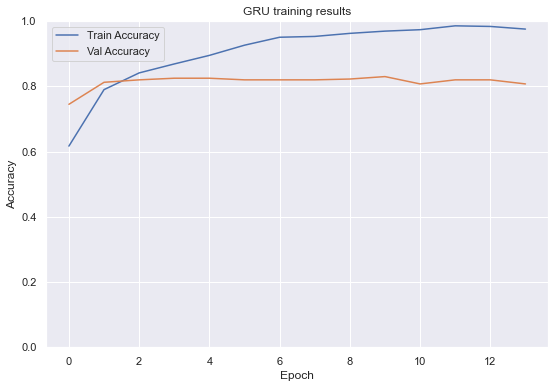

In [273]:
# plotting the learning curve
plot_history(history, 'GRU training results')

Accuracy: 0.8
Confusion matrix:


<AxesSubplot:>

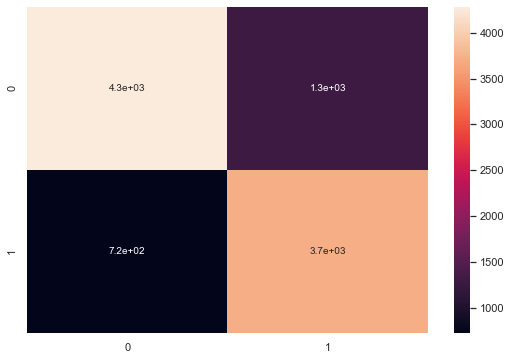

In [274]:
# testing
list_tokenized_test = tokenizer.texts_to_sequences(data_test_lemma)
x_test = pad_sequences(list_tokenized_test, maxlen=300)

prediction = model.predict(x_test)
y_pred = (prediction > 0.5)
print('Accuracy: {0}'.format(accuracy_score(y_pred, target_test)))
print('Confusion matrix:')
sns.heatmap(confusion_matrix(y_pred, target_test)*20, annot=True)

Once again we obtain similar (slightly worse) accuracy score and learning curve, shorter due to early stopping.

### II.V RNN model - LSTM + GloVe embedding (additional)

In [244]:
embedding_vector = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

400000it [00:14, 27297.96it/s]


In [245]:
embedding_matrix = np.zeros((vocab_size,100))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|████████████████████████████████████████████████████████████████████████| 22581/22581 [00:00<00:00, 370198.48it/s]


In [250]:
embid_dim = 100
lstm_out = 128

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length =100, weights = [embedding_matrix ] , trainable = False))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

In [251]:
# callback that saves the model's weights
checkpoint_path = "checkpoints/glove"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# early stopping on val_loss
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [252]:
# optimizer and metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [253]:
# training
batch_size = 1000
epochs = 20
history = model.fit(
    x_train, y, epochs=epochs, validation_split = 0.2, batch_size=batch_size, callbacks=[early_stop, cp_callback])

Epoch 1/20
32/32 [==============================] - 25s 699ms/step - loss: 0.6965 - accuracy: 0.5435 - val_loss: 0.6524 - val_accuracy: 0.6625

Epoch 00001: saving model to checkpoints\glove
Epoch 2/20
32/32 [==============================] - 17s 531ms/step - loss: 0.6085 - accuracy: 0.7193 - val_loss: 0.5954 - val_accuracy: 0.6925

Epoch 00002: saving model to checkpoints\glove
Epoch 3/20
32/32 [==============================] - 19s 584ms/step - loss: 0.5243 - accuracy: 0.7407 - val_loss: 0.4989 - val_accuracy: 0.7500

Epoch 00003: saving model to checkpoints\glove
Epoch 4/20
32/32 [==============================] - 19s 600ms/step - loss: 0.4741 - accuracy: 0.7848 - val_loss: 0.4535 - val_accuracy: 0.7725

Epoch 00004: saving model to checkpoints\glove
Epoch 5/20
32/32 [==============================] - 20s 621ms/step - loss: 0.4550 - accuracy: 0.7915 - val_loss: 0.4425 - val_accuracy: 0.7975

Epoch 00005: saving model to checkpoints\glove
Epoch 6/20
32/32 [===========================

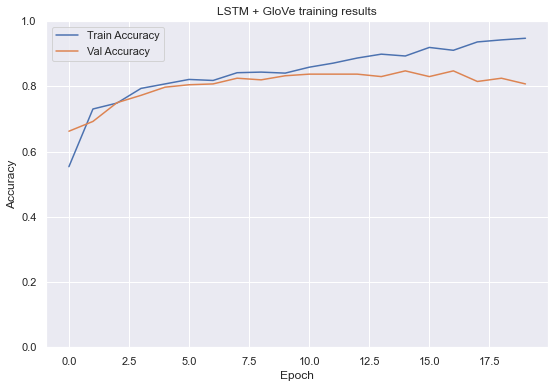

In [254]:
# plotting the learning curve
plot_history(history, 'LSTM + GloVe training results')

Accuracy: 0.81
Confusion matrix:


<AxesSubplot:>

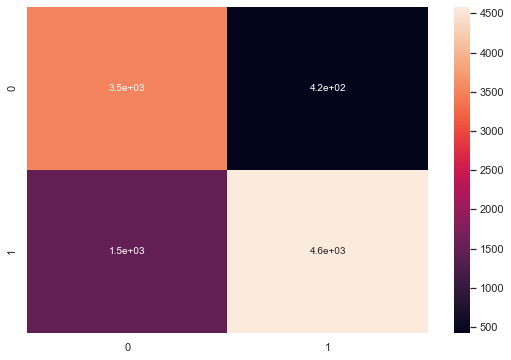

In [255]:
# testing
list_tokenized_test = tokenizer.texts_to_sequences(data_test_lemma)
x_test = pad_sequences(list_tokenized_test, maxlen=300)

prediction = model.predict(x_test)
y_pred = (prediction > 0.5)
print('Accuracy: {0}'.format(accuracy_score(y_pred, target_test)))
print('Confusion matrix:')
sns.heatmap(confusion_matrix(y_pred, target_test), annot=True)

Using different embedding, we get better learning curve (smaller difference between train and validation) but accuracy stays around the same value (0.81).

## III. Conclusions

* RNN are complicated models with many parameters to tune, including the number of layers and the number of neurons on them, or activation functions used. It is hard to execute proper grid search as it is very time consuming in case of big datasets.
* With little tuning we are able to achieve accuracy around 0.85 which isn't bad given the small number of epochs.
* Learning curves show that we deal with overfitting. Given the complexity of the model it is hard to find a cause - maybe we use too big network.
* Despite all of the above neural network with random/default parameters, after little number of epochs, gave better accuracy than tuned linear (logistic) model.